# Conformal prediction for classification

In [689]:
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from mapie.classification import MapieClassifier

Conformal prediction ({cite:t}`vovk_al,shaf_at08,bala_cp`) is a framework for reliable prediction that is rooted in classical frequentist statistics, more specifically in hypothesis testing[^revision].
Given a sequence of training observations and a new query $\vec{x}_{N+1}$ (which we denoted by $\vec{x}_{q}$ before and in the following plot is marked red) with unknown outcome $y_{N+1}$,

$$
(\vec{x}_1, y_1), \,  (\vec{x}_2, y_2), \ldots ,  (\vec{x}_N, y_N), \, (\vec{x}_{N+1}, \bullet)
\enspace ,
$$(cpseq)

[^revision]: If this concept is new to you we recommend visiting our site on Hypothesis Testing {doc}`hypothesis-excurs`.

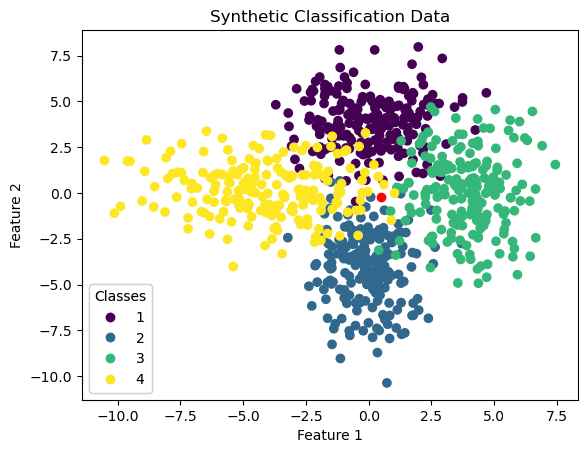

In [690]:
n_samples = 200
n_classes = 4
classes = list(range(1,n_classes+1))
random_state = 41

# parameters for toy data
means = [(0,4),(0,-4),(4,0),(-4,0)]
covs = [np.eye(2)*2.5,np.diag([1.5,3.5]), np.diag([1.5,4.5]), np.diag([5,2])]

epsilon = 0.05 # This choice is the central point of conformel prediction

np.random.seed(random_state)

X = np.vstack([
    np.random.multivariate_normal(mean,cov,n_samples) 
    for mean,cov in zip(means,covs)
])
y = np.hstack([np.full(n_samples,i) for i in classes])

x_new = np.array([0.5, -0.2])

fig, ax = plt.subplots()

ax.set_title("Synthetic Classification Data")

scatter = ax.scatter(X[:, 0], X[:, 1], c=y)
ax.scatter(*x_new, c="r")

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
ax.add_artist(legend1)

ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
plt.show()

the basic idea is to hypothetically replace $\bullet$ by each candidate, i.e., to test the hypothesis $y_{N+1} = y$ for all $y \in \mathcal{Y}$. Only those outcomes $y$ for which this hypothesis can be rejected at a predefined level of confidence are excluded, while those for which the hypothesis cannot be rejected are collected to form the prediction set or *prediction region* $Y^\epsilon \subseteq \mathcal{Y}$. The construction of a set-valued prediction $Y^\epsilon = Y^\epsilon(\vec{x}_{n+1})$ that is guaranteed to cover the true outcome $y_{N+1}$ with a given probability $1- \epsilon$ (for example 95\,\%), instead of producing a point prediction $\hat{y}_{N+1} \in \mathcal{Y}$, is the basic idea of conformal prediction. Here, $\epsilon \in (0,1)$ is a pre-specified level of significance. In the case of classification, $Y^\epsilon$ is a subset of the set of classes $\mathcal{Y} = \{ y_1, \ldots , y_K \}$, whereas in regression, a prediction region is commonly represented in terms of an interval[^regressionCase].

[^regressionCase]: Obviously, since $\mathcal{Y} = \mathbb{R}$ is infinite in regression, a hypothesis test cannot be conducted explicitly for each candidate outcome $y$. 

Hypothesis testing is done in a nonparametric way: Consider any ''nonconformity'' function $f: \, \mathcal{X} \times \mathcal{Y} \longrightarrow \mathbb{R}$ that assigns scores $\alpha = f(\vec{x}, y)$ to input/output tuples; the latter can be interpreted as a measure of ''strangeness'' of the pattern $(\vec{x}, y)$, i.e., the higher the score, the less the data point $(\vec{x}, y)$ conforms to what one would expect to observe.
```{note}
The error bounds are valid and well calibrated by construction, regardless of the nonconformity function $f$. However, the choice of this function has an important influence on the *efficiency* of conformal prediction, that is, the size of prediction regions: The more suitable the nonconformity function is chosen, the smaller these sets $Y^\epsilon$ will be. 
```

An example of a nonconformity score based on $k$ nearest neighbors:

$$
f(\vec{x},y) = \frac{\sum_{i=1}^k d_i^+}{\sum_{i=1}^k d_i^-}
$$

where $d_i^+$ is the distance from the $i^{th}$ nearest neighbor labeled y, and $d_i^-$ the distance from the $i^{th}$ nearest neighbor labeled differently.

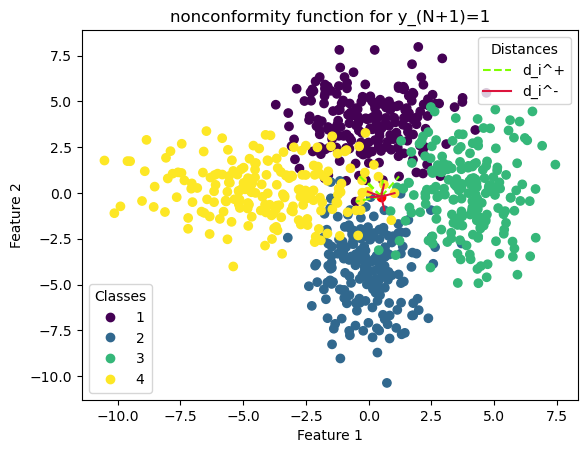

In [691]:
def euclidean_distance(x, data):
    dist = np.linalg.norm(
        x - data, axis=1, ord=2
    )  # L2-norm (euclidean distance between x and all data points in X)
    return dist


def nearest_neighbors_idx(distances, k=5):
    idx = np.argpartition(
        distances, k
    )  # makes the kth element as pivot such that left from it are all smaller elements
    return idx[:k]


def nearest_neighbors_distance(x, data, k=5):
    dist = euclidean_distance(x, data)
    idx = nearest_neighbors_idx(dist, k)
    return dist[idx]  # get the distances of the k nearest neighbors


def split_data_classes(y_i, X, y):
    # create two datasets one where each point has the same class as y_i the other points in the second dataset.
    mask_same_class = y == y_i
    data_with_same_class = X[mask_same_class, :]
    data_with_other_class = X[~mask_same_class, :]
    return data_with_same_class, data_with_other_class


def nonconformity_function(x_i, y_i, X, y):
    data_with_same_class, data_with_other_class = split_data_classes(y_i, X, y)
    distance_to_same_class = np.sum(
        nearest_neighbors_distance(x_i, data_with_same_class, k=5)
    )
    distance_to_other_class = np.sum(
        nearest_neighbors_distance(x_i, data_with_other_class, k=5)
    )

    return distance_to_same_class / distance_to_other_class


def plot_nearest_neighbors_distance(y_new, ax):
    ax.set_title(f"nonconformity function for y_(N+1)={y_new}")

    scatter = ax.scatter(X[:, 0], X[:, 1], c=y)
    ax.scatter(*x_new, c="red")

    # visualize the distance to the equally labeled points:
    data_with_same_class, data_with_other_class = split_data_classes(y_new, X, y)
    for i in nearest_neighbors_idx(
        euclidean_distance(x_new, data_with_same_class), k=5
    ):
        x_values = [x_new[0], data_with_same_class[i, 0]]
        y_values = [x_new[1], data_with_same_class[i, 1]]
        (line1,) = ax.plot(
            x_values, y_values, linestyle="--", c="chartreuse", label="d_i^+"
        )

    # visualize the distance to the differently labeled points:
    for i in nearest_neighbors_idx(
        euclidean_distance(x_new, data_with_other_class), k=5
    ):
        x_values = [x_new[0], data_with_other_class[i, 0]]
        y_values = [x_new[1], data_with_other_class[i, 1]]
        (line2,) = ax.plot(
            x_values, y_values, linestyle="-", c="crimson", label="d_i^-"
        )

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
    ax.add_artist(legend1)

    # produce a legend with the distance
    ax.legend(handles=[line1, line2], loc="upper right", title="Distances")

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")


fig, ax = plt.subplots()
plot_nearest_neighbors_distance(y_new=1, ax=ax)
# plot_nearest_neighbors_distance(y_new=1, ax=ax)
# plot_nearest_neighbors_distance(y_new=2, ax=ax)
# plot_nearest_neighbors_distance(y_new=3, ax=ax)
plt.show()

Applying this function to the sequence {eq}`cpseq`, with a specific (though hypothetical) choice of $y = y_{N+1}$ (let us pick y = 0), yields a sequence of scores

$$
\alpha_1, \, \alpha_2, \ldots , \alpha_N , \, \alpha_{N+1} \enspace .
$$

In [692]:
def get_nonconformityScores(x_new, y_new):
    data = np.concatenate((X, y.reshape(-1, 1)), axis=1)  # merge X and y into one array
    new_point = np.hstack((x_new, y_new))  # make the new data point
    complete_data = np.vstack((data, new_point))  # put all together

    resulting_scores = np.array(
        [
            nonconformity_function(
                x_i=complete_data[i, :-1],
                y_i=complete_data[i, -1],
                X=np.delete(complete_data, i, axis=0)[:, :-1],
                y=np.delete(complete_data, i, axis=0)[:, -1],
            )
            for i in range(complete_data.shape[0])
        ]
    )

    return resulting_scores

alpha_values_y1 = get_nonconformityScores(x_new=x_new,y_new=1)
alpha_values_y1[-10:] # get the last 10 non-conformity scores

array([0.21646819, 3.172133  , 1.02730398, 0.19551762, 0.11003534,
       0.08746993, 0.14243255, 1.1078807 , 0.75476198, 1.93193947])

Denote by $\sigma$ the permutation of $\{1, \ldots , N+1\}$ that sorts the scores in increasing order, i.e., such that $\alpha_{\sigma(1)} \leq \ldots \leq \alpha_{\sigma(N+1)}$. Under the assumption that the hypothetical choice of $y_{N+1}$ is in agreement with the true data-generating process, and that this process has the property of exchangeability (which is weaker than the assumption of independence and essentially means that the order of observations is irrelevant), every permutation $\sigma$ has the same probability of occurrence. Consequently, the probability that $\alpha_{N+1}$ is among the $\epsilon$\,\% highest nonconformity scores should be low. This notion can be captured by the $p$-values associated with the candidate $y$, defined as 

$$
p(y)   := \frac{\# \{ i \given \alpha_i \geq \alpha_{N+1} \}}{N+1}
$$

In [693]:
def calculate_probability(nonconformity_sequence):
    # calculate the proportion that atleast the new datapoints nonconformity score occurs.
    new_datapoint_nonconformityScore = nonconformity_sequence[-1]
    probability = np.sum(
        nonconformity_sequence >= new_datapoint_nonconformityScore
    ) / len(
        nonconformity_sequence
    )  # the N + 1 is inherently in the length of the sequence
    return probability

probability_y1 = calculate_probability(alpha_values_y1)
probability_y1

0.03870162297128589

According to what we said, the probability that $p(y) < \epsilon$ (i.e., $\alpha_{N+1}$ is among the $\epsilon$\,\% highest $\alpha$-values) is upper-bounded by $\epsilon$. 
Thus, the hypothesis $y_{N+1} = y$ can be rejected for those candidates $y$ for which $p(y) < \epsilon$. 
For the initial choice y = 1 we can reject this candidate, because $p(y) \approx 0.038 < 0.05 = \epsilon$.
The complete $Y_\epsilon$ can then be constructed iterating through all possible candidates $y = y_{N+1}$. 

In [694]:
probabilities = {possible_class: calculate_probability(get_nonconformityScores(x_new, possible_class))
                 for possible_class in classes}

Y_hat = np.array(
    [
        prediction
        for prediction,probability in probabilities.items()
        if probability >= 0.05
    ]
)
Y_hat

array([2, 4])

Conformal prediction as outlined above realizes transductive inference, although inductive variants also exist ({cite:t}`papa_ic08`). For transductive inference the non-conformity scores $\alpha_1, \, \alpha_2, \ldots , \alpha_N , \, \alpha_{N+1}$ have to re-calculated for each new proposal $y_{N+1}=y$. In inductive inference this problem is solved by using an *calibration* dataset. Many packages have already been published implementing the inductive inference, such as [MAPIE](https://mapie.readthedocs.io/en/latest/index.html). We again use the above mentioned synthetic dataset and split it into $l$ training, $k$ validation and $(n-(l+k))$ testing points.

```{note}
From an usage aspect is not necessary to split the data into train and validation beforehand. 
The *MapieClassifier* would do this automatically controlled by the parameter `cv`. 
Here we want to illustrate therefore we choose `cv="prefit"`
```

In [695]:
X_val,X_test,y_val,y_test = train_test_split(X,
                                             y,
                                             train_size=0.8,
                                             random_state=random_state)
X_train,X_val,y_train,y_val = train_test_split(X_val,
                                               y_val,
                                               train_size=0.8,
                                               random_state=random_state)

In the next step we take an arbitrary classifier such as the [Gaussian Naive Bayes classifier](https://scikit-learn.org/stable/modules/naive_bayes.html) and train it on the classification dataset. Then on the validation dataset the corresponding non-conformity scores are computed. For this a corresponding non-conformity function $f$ has to be defined. We will use the *Least Ambiguous Set-Valued Classifier* method {cite:t}`LAC_Method`.

$$
    f(\vec{x},y) = 1 - \hath(\vec{x})_y
$$

where $\hath$ is a classifier and $\hath(x)_y$ the probability of classifying the data point $x$ as $y$ under $\hath$. 
Applying this function to the validation dataset yields a sequence of non-conformity scores $\alpha_{l+1}, \, \alpha_{l+2}, \ldots , \alpha_{l+k-1}, \alpha_{l+k}$ which can be represented by the below Histogram.

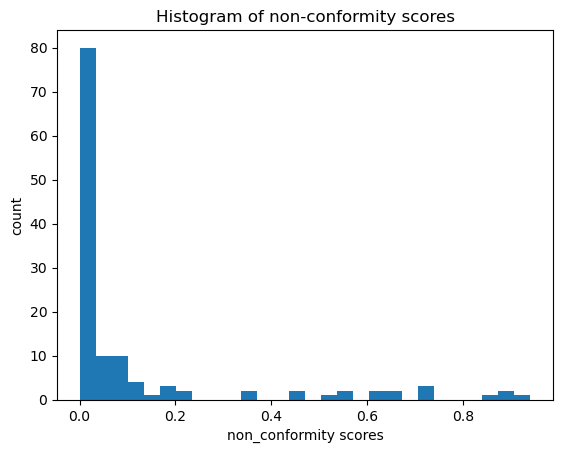

In [696]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train,y_train)

conformel_classifier = MapieClassifier(naive_bayes,
                                       method="lac",
                                       cv="prefit", 
                                       random_state=random_state)
conformel_classifier.fit(X_val,y_val)

# Plot the score distribution
non_conformity_scores = conformel_classifier.conformity_scores_

fig, ax = plt.subplots()
ax.hist(non_conformity_scores, bins="auto")

ax.set_title("Histogram of non-conformity scores")
ax.set_xlabel("non_conformity scores")
ax.set_ylabel("count")

plt.show()

Now given a $\epsilon$ one can define based on the above distribution an threshold $t$ such that all candidates $y_{N+1}=y$ can be rejected if $f(x_{N+1},y_{N+1}) \geq t$. The value of $t$ is deduced from the above distribution with the additionally value $f(x_{N+1},y_{N+1})$. Thus in comparison to the tranductive conformel prediction the non-conformity scores of the validation set is fixed and the threshold differes for each $x_{N+1}$ and $\epsilon$.

In [697]:
def to_predictionSet(predicton_set_indicator):    
    n_samples, n_classes, n_alpha = predicton_set_indicator.shape

    prediction_sets_with_zero_fills = predicton_set_indicator * np.array(classes)[None, :, None]

    datapoint_sets = [[]] * n_alpha # we need so many prediction sets for each data point as we defined alpha values
    prediction_sets =[datapoint_sets] * n_samples
    for sample in range(n_samples):
        for epsilon in range(n_alpha):
            current_mask = (
                prediction_sets_with_zero_fills[sample, :, epsilon] > 0
            )  # mask to indicate the classes included in set
            prediction_sets[sample][epsilon] = set(prediction_sets_with_zero_fills[
                sample, :, epsilon
            ][
                current_mask
            ])  # put these values in the prediction set
    return prediction_sets

In [698]:
point, prediction_set_indicator = conformel_classifier.predict(
    x_new.reshape(1, -1), alpha=[0.05, 0.1]
)  # note epsilon == alpha
print("Point estimate: ", point)
print(
    "Prediction Indicator Set(alpha=0.05; alpha=0.1): \n", prediction_set_indicator
)  # The prediction set indicates whether the corresponding class is contained in the set
print("Prediction sets (alpha=.05; alpha=0.1): \n", to_predictionSet(predicton_set_indicator=prediction_set_indicator))

Point estimate:  [2]
Prediction Indicator Set(alpha=0.05; alpha=0.1): 
 [[[False False]
  [ True  True]
  [False False]
  [ True False]]]
Prediction sets (alpha=.05; alpha=0.1): 
 [[{2, 4}, {2}]]


## Uncertainty Quantification in Conformel prediction
Although conformal prediction is mainly concerned with constructing prediction regions, the scores produced in the course of this construction can also be used for quantifying uncertainty. In this regard, the notions of *confidence* and *credibility* have been introduced ({cite:t}`gam_pa02`): Let $p_1, \ldots , p_K$ denote the $p$-values that correspond, respectively, to the candidate outcomes $y_1, \ldots , y_K$ in a classification problem.

In [699]:
probabilities

{1: 0.03870162297128589,
 2: 0.09238451935081149,
 3: 0.04868913857677903,
 4: 0.11610486891385768}

If a definite choice (point prediction) $\hat{y}$ has to be made, it is natural to pick the $y_i$ with the highest $p$-value. The value $p_i$ itself is then a natural measure of credibility, since the larger (closer to 1) this value, the more likely the prediction is correct. Note that the value also corresponds to the largest significance level $\epsilon$ for which the prediction region $Y^\epsilon$ would be empty (since all candidates would be rejected). In other words, it is a degree to which $y_i$ is indeed a plausible candidate that cannot be excluded. Another question one may ask is to what extent $y_i$ is the unique candidate of that kind, i.e., to what extent other candidates can indeed be excluded. This can be quantified in terms of the greatest $1 - \epsilon$ for which $Y^\epsilon$ is the singleton set $\{ y_i \}$, that is, $1$ minus the second-highest $p$-value. Besides, other methods for quantifying the uncertainty of a point prediction in the context of conformal prediction have been proposed ({cite:t}`linu_rc16`). 

In [700]:
def get_pointPrediction(probabilities):
    y_hat = max(probabilities, key=probabilities.get)
    sorted_probabilities = sorted(probabilities.values())
    print("Credability: ", sorted_probabilities[-1])
    print("Confidence: ", 1- sorted_probabilities[-2])
    return y_hat
get_pointPrediction(probabilities)

Credability:  0.11610486891385768
Confidence:  0.9076154806491885


4

<div align="justify">

With its main concern of constructing valid prediction regions, conformal prediction differs from most other machine learning methods, which produce point predictions $y \in \mathcal{Y}$, whether equipped with a degree of uncertainty or not. In a sense, conformal prediction can even be seen as being orthogonal: It predefines the degree of uncertainty (level of confidence) and adjusts its prediction correspondingly, rather than the other way around. 

</div>